In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyter_core import paths
paths.jupyter_config_path()

['/Users/joeyer/Documents/Code/blackbirds/etc/jupyter',
 'Users/joeyer/.jupyter/',
 '/usr/local/etc/jupyter',
 '/etc/jupyter']

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scistats
import torch
import torch.distributions

from blackbirds import mcmc

## Conjugate Normal

In [99]:
mu_0, sigma_0 = 1., 2.
prior = torch.distributions.normal.Normal(mu_0, sigma_0)

In [100]:
sigma = 1.

def negative_log_likelihood(data, theta):
    dist = torch.distributions.normal.Normal(theta, sigma)
    return - dist.log_prob(data).sum()

In [150]:
data_size = 3
data = torch.distributions.normal.Normal(-1., sigma).sample((data_size,))

In [151]:
data

tensor([ 0.3026,  2.3323, -0.4167])

### Sampling

In [152]:
mala = mcmc.MALA(prior, negative_log_likelihood, w=1.)

In [153]:
sampler = mcmc.MCMC(mala, 100_000)

In [154]:
trial_samples = sampler.run(data, torch.tensor([-.5]), verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:29<00:00, 3430.85it/s, Acceptance rate=0.00281, Dim=torch.Size([1])]


In [155]:
thinned_trial_samples = torch.stack(trial_samples)[::100].T
scale = torch.cov(thinned_trial_samples)

In [156]:
mala = mcmc.MALA(prior, negative_log_likelihood, 1.)
sampler = mcmc.MCMC(mala, 100_000)
post_samples = sampler.run(data, torch.tensor([thinned_trial_samples.mean()]), scale=scale, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3262.84it/s, Acceptance rate=0.00776, Dim=torch.Size([1])]


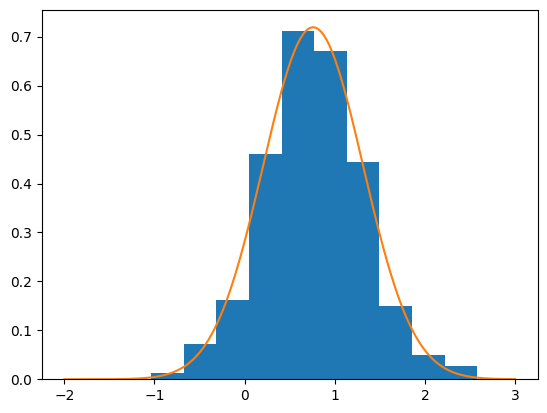

In [160]:
plt.hist(torch.stack(post_samples).T.numpy()[0, ::100], density=True)
x = np.linspace(-2, 3., 1000)
plt.plot(x, scistats.norm.pdf(x, 
                              (mu_0/sigma_0**2 + data.sum()/sigma**2)/(1/sigma_0**2 + data_size/sigma**2),
                              1/np.sqrt((1/sigma_0**2 + data_size/sigma**2))))

## Conjugate multivariate Normal 

In [167]:
mu_0, sigma_0 = torch.tensor([2., 0.]), torch.tensor([[2., 0.,], [0., 1.]])
prior = torch.distributions.multivariate_normal.MultivariateNormal(mu_0, sigma_0)

(-2.0, 6.0)

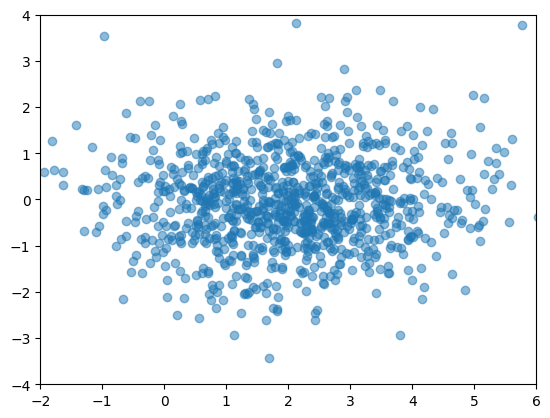

In [172]:
prior_samples = prior.sample((1000,))
plt.scatter(prior_samples[:,0], prior_samples[:, 1], alpha=0.5)
plt.ylim([-4,4])
plt.xlim([-2,6])

In [187]:
sigma = torch.tensor([[1., 0.4,], [0.4, 2.]])

def negative_log_likelihood(data, theta):
    dist = torch.distributions.multivariate_normal.MultivariateNormal(theta, sigma)
    return - dist.log_prob(data).sum()

In [176]:
data_size = 3
true_mean = torch.tensor([-1., 2.])
true_density = torch.distributions.multivariate_normal.MultivariateNormal(true_mean, sigma)
data = true_density.sample((data_size,))

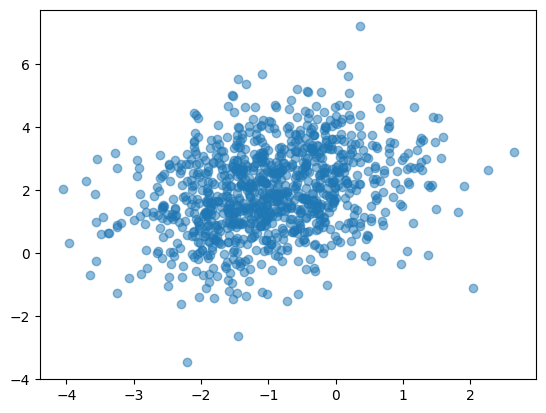

In [177]:
true_density_samples = true_density.sample((1000,))
plt.scatter(true_density_samples[:,0], true_density_samples[:,1], alpha=0.5)

In [178]:
data

tensor([[-2.0651,  3.5088],
        [-1.1175,  0.3114],
        [-3.9153,  0.2007]])

### Sampling

In [188]:
mala = mcmc.MALA(prior, negative_log_likelihood, w=1.)

In [189]:
sampler = mcmc.MCMC(mala, 100_000)

In [190]:
trial_samples = sampler.run(data, torch.tensor([-2., -.5]), verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:36<00:00, 2755.61it/s, Acceptance rate=0.000162, Dim=torch.Size([2])]


In [191]:
thinned_trial_samples = torch.stack(trial_samples)[::100].T
cov = torch.cov(thinned_trial_samples)

In [193]:
init_state = thinned_trial_samples.mean(dim=1)

In [200]:
mala = mcmc.MALA(prior, negative_log_likelihood, 1.)
sampler = mcmc.MCMC(mala, 100_000)
post_samples = sampler.run(data, init_state, covariance=cov, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2693.53it/s, Acceptance rate=0.653]


In [198]:
inv_sigma_0 = torch.inverse(sigma_0)
inv_sigma = torch.inverse(sigma)
inv_additions = torch.inverse(inv_sigma_0 + data_size*inv_sigma)
true_mean = torch.matmul(inv_additions, 
                         (torch.matmul(inv_sigma_0, mu_0) + data_size*torch.matmul(inv_sigma, data.mean(dim=0))))
true_cov = torch.inverse(inv_sigma_0 + data_size*inv_sigma)
true_post = torch.distributions.multivariate_normal.MultivariateNormal(true_mean, true_cov)
true_post_samples = true_post.sample((1000,))

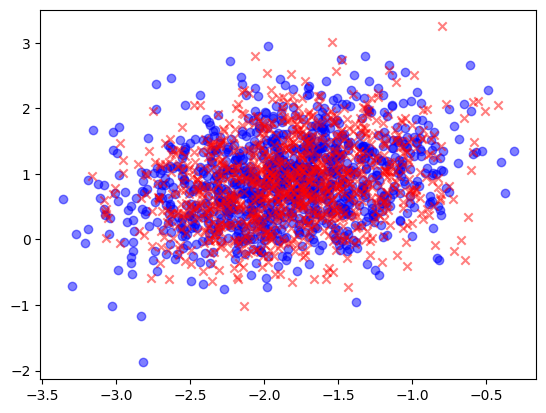

In [201]:
post_samples_numpy = torch.stack(post_samples).T.numpy()
plt.scatter(post_samples_numpy[0, ::100], post_samples_numpy[1, ::100], alpha=0.5, c='b')
plt.scatter(true_post_samples[:, 0], true_post_samples[:, 1], alpha=0.5, c='r', marker='x')